In [51]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [22]:
files = {
    "smooth": "smooth_montage.png",
    "edge_dominant": "edge_montage.png",
    "textured": "textured_montage.png"
}

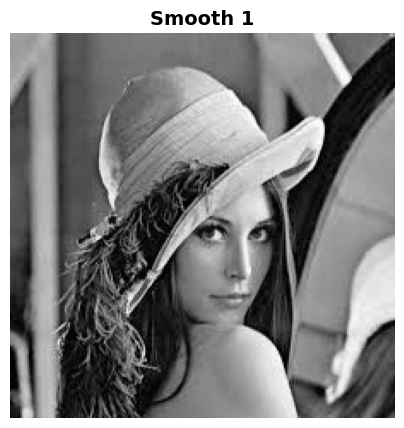

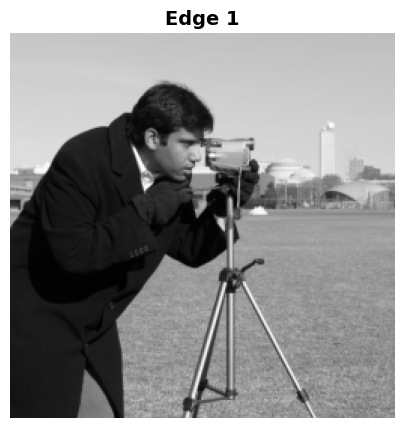

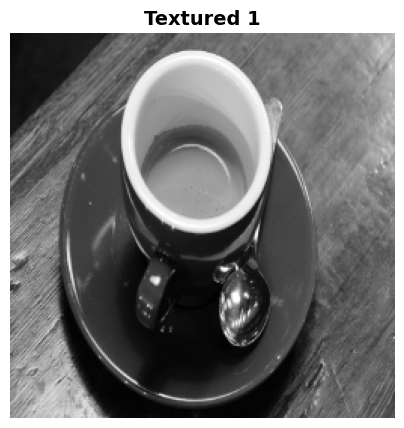

In [43]:
def get_first_tile(file, rows, cols, title):
    img = Image.open(file).convert("L")  
    w, h = img.size
    tile_w, tile_h = w // cols, h // rows

    left, upper = 0, 0
    right, lower = tile_w, tile_h
    tile = img.crop((left, upper, right, lower))
    tile_array = np.array(tile)

    plt.figure(figsize=(5, 5))
    plt.imshow(tile_array, cmap="gray")
    plt.title(f"{title} 1", fontsize=14, fontweight="bold")
    plt.axis("off")
    plt.show()

    return tile_array


smooth_1   = get_first_tile("smooth_montage.png", rows=1, cols=7, title="Smooth")
edge_1     = get_first_tile("edge_montage.png", rows=1, cols=7, title="Edge")
textured_1 = get_first_tile("textured_montage.png", rows=1, cols=7, title="Textured")

In [65]:
def apply_svd(image):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    return U, S, VT

In [66]:
svd_results = {}
for name, gray_img in images.items():
    U, S, VT = apply_svd(gray_img)
    svd_results[name] = (U, S, VT)
    print(f"--- {name.capitalize()} Image ---")
    print(f"U shape: {U.shape}")
    print(f"S shape: {S.shape}")
    print(f"VT shape: {VT.shape}")
    print("\n")

--- Smooth Image ---
U shape: (225, 225)
S shape: (225,)
VT shape: (225, 1575)


--- Edge_dominant Image ---
U shape: (256, 256)
S shape: (256,)
VT shape: (256, 1792)


--- Textured Image ---
U shape: (256, 256)
S shape: (256,)
VT shape: (256, 1792)




In [67]:
def reconstruct_image(U, S, VT, k):
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vk = VT[:k, :]
    return np.dot(Uk, np.dot(Sk, Vk))

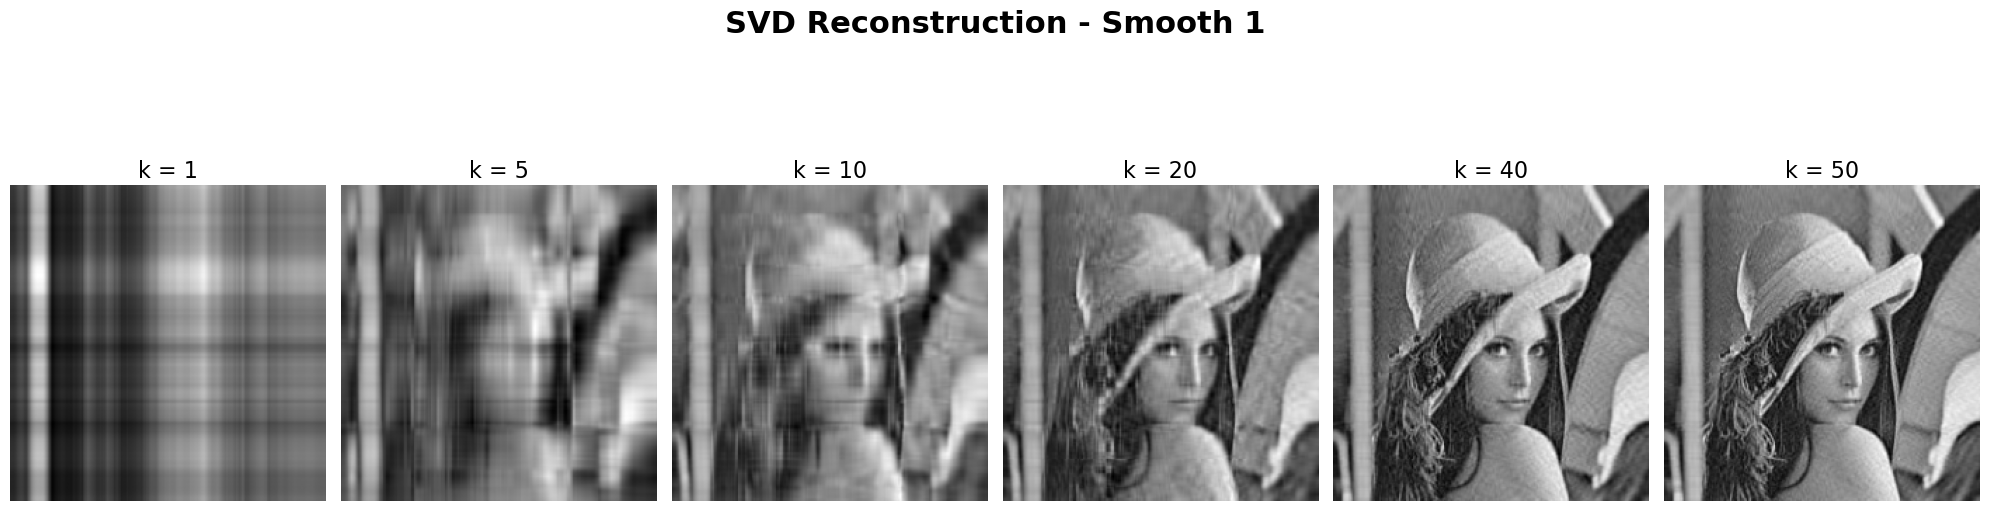

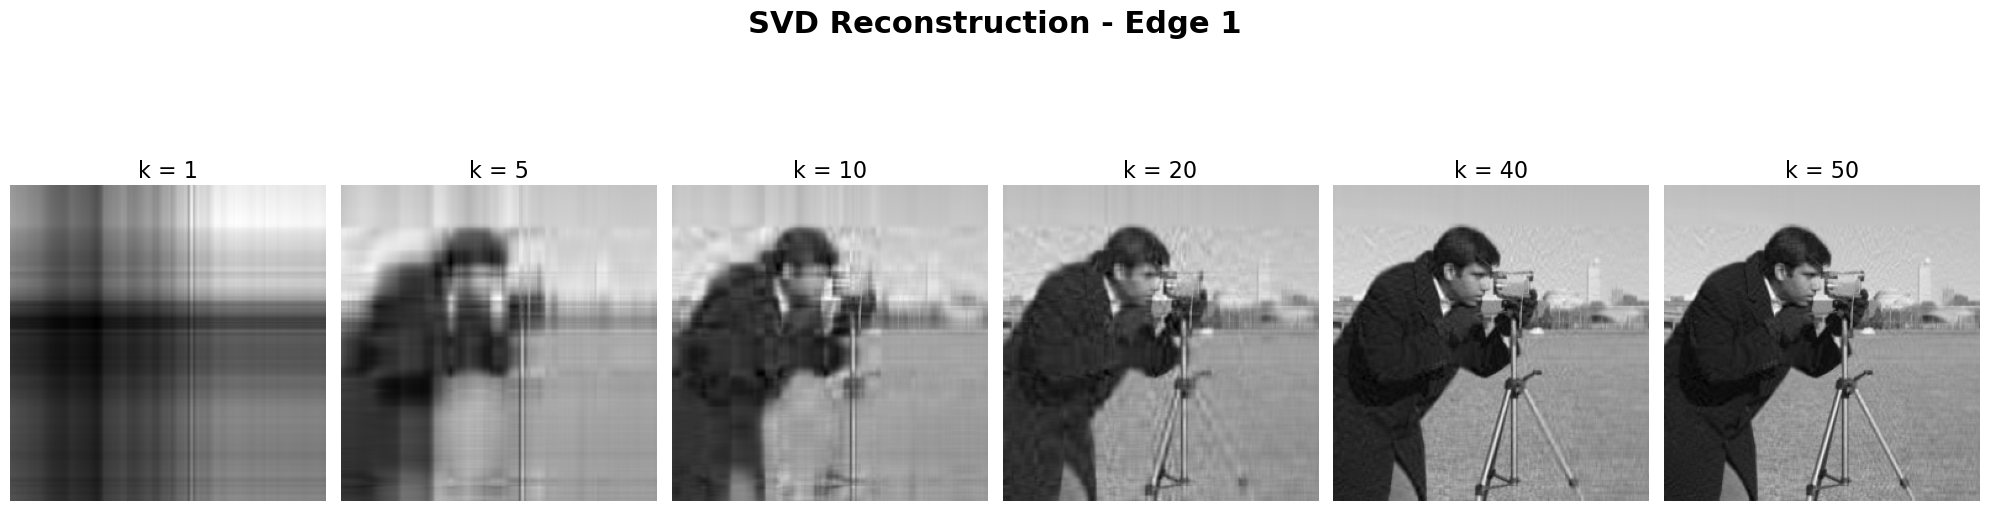

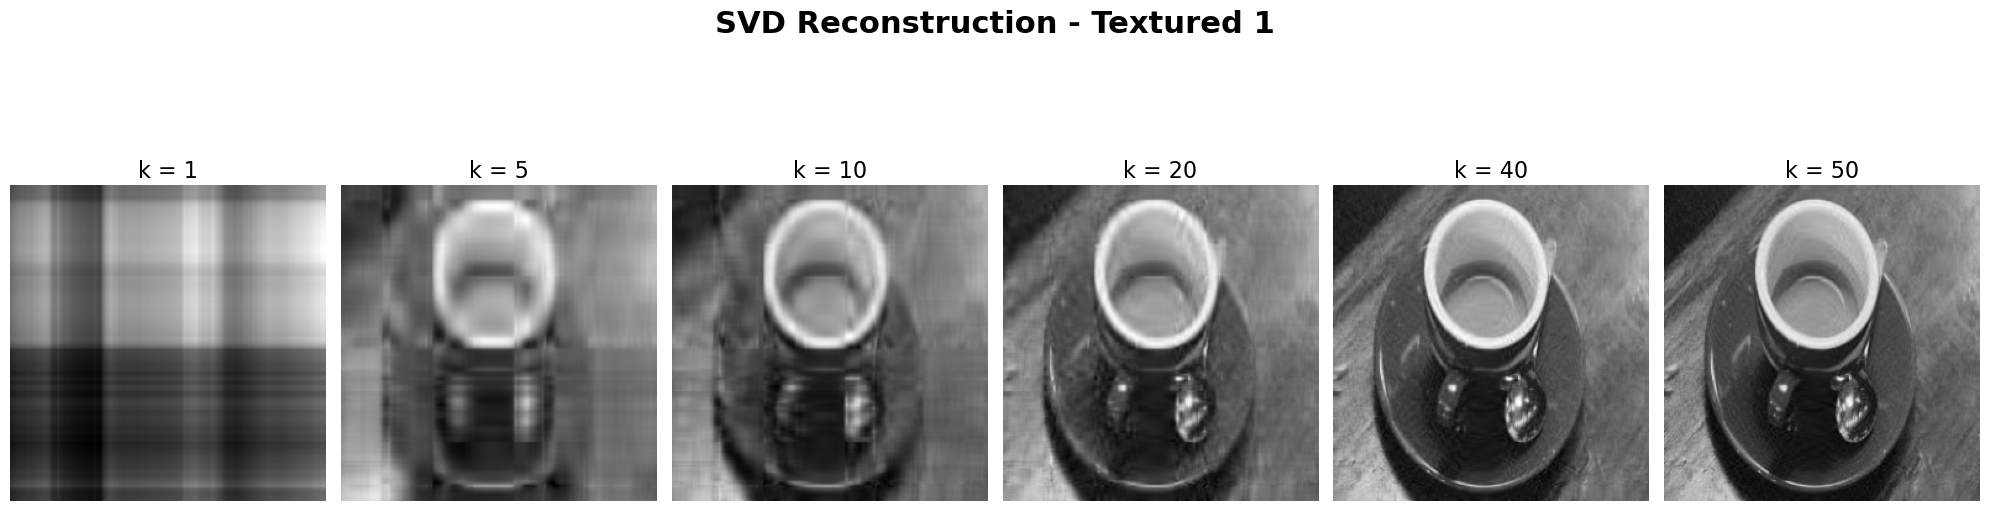

In [47]:
k_values = [1, 5, 10, 20, 40, 50]

selected_images = {
    "Smooth 1": smooth_tiles[0],
    "Edge 1": edge_tiles[0],
    "Textured 1": text_tiles[0]
}

for name, img in selected_images.items():
    U, S, VT = np.linalg.svd(img, full_matrices=False)

    plt.figure(figsize=(20, 6)) 
    plt.suptitle(f"SVD Reconstruction - {name}", fontsize=22, fontweight="bold", y=1.02)

    for i, k in enumerate(k_values):
        approx_img = reconstruct_image(U, S, VT, k)

        plt.subplot(1, 6, i+1) 
        plt.imshow(approx_img, cmap="gray")
        plt.title(f"k = {k}", fontsize=16)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [48]:
def compression_ratio(img, k):
    m, n = img.shape
    original_size = m * n
    compressed_size = k * (m + n + 1)
    return original_size / compressed_size

k_values = [1, 5, 10, 20, 40, 50]

compression_results = {}

for name, img in {"Smooth 1": smooth_1, "Edge 1": edge_1, "Textured 1": textured_1}.items():
    ratios = {}
    for k in k_values:
        ratios[k] = compression_ratio(img, k)
    compression_results[name] = ratios

import pandas as pd
df = pd.DataFrame(compression_results)
print(df)

      Smooth 1      Edge 1  Textured 1
1   112.250554  127.750487  127.750487
5    22.450111   25.550097   25.550097
10   11.225055   12.775049   12.775049
20    5.612528    6.387524    6.387524
40    2.806264    3.193762    3.193762
50    2.245011    2.555010    2.555010


In [68]:
def load_images(filename):
    with open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        buffer = f.read(rows * cols * num_images)
        data = np.frombuffer(buffer, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
        return data

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        buffer = f.read(num_labels)
        labels = np.frombuffer(buffer, dtype=np.uint8)
        return labels

In [69]:
train_images_file = "train-images.idx3-ubyte"
train_labels_file = "train-labels.idx1-ubyte"
test_images_file = "t10k-images.idx3-ubyte"
test_labels_file = "t10k-labels.idx1-ubyte"

X_train = load_images(train_images_file)
y_train = load_labels(train_labels_file)
X_test = load_images(test_images_file)
y_test = load_labels(test_labels_file)

print("Training images shape:", X_train.shape)  
print("Training labels shape:", y_train.shape) 
print("Test images shape:", X_test.shape)       
print("Test labels shape:", y_test.shape)       

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


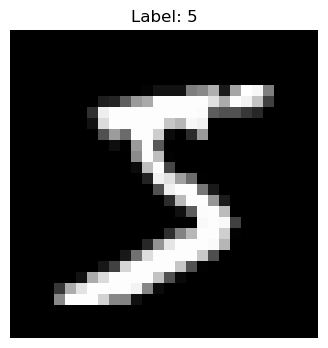

In [70]:
plt.figure(figsize=(4,4))
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

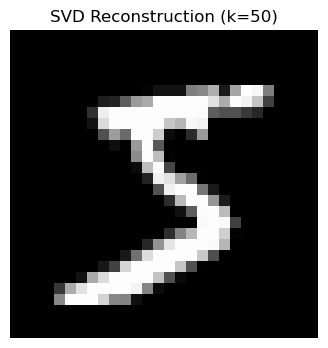

In [71]:
sample_image = X_train[0]

U, S, VT = np.linalg.svd(sample_image, full_matrices=False)
k = 50
S_reduced = np.diag(S[:k])
reconstructed_svd = np.dot(U[:, :k], np.dot(S_reduced, VT[:k, :]))

plt.figure(figsize=(4,4))
plt.imshow(reconstructed_svd, cmap='gray')
plt.title(f"SVD Reconstruction (k={k})")
plt.axis('off')
plt.show()

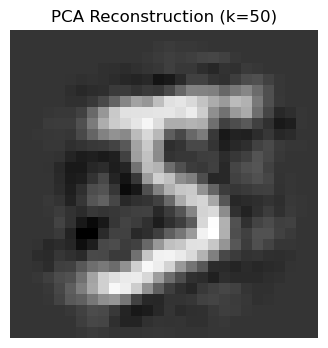

In [72]:
from sklearn.decomposition import PCA

X_train_flat = X_train[:500].reshape(500, 28*28)

k = 50  

pca = PCA(n_components=k)
pca.fit(X_train_flat) 

sample_flat = X_train_flat[0].reshape(1, -1)
reconstructed_pca = pca.inverse_transform(pca.transform(sample_flat)).reshape(28, 28)

plt.figure(figsize=(4,4))
plt.imshow(reconstructed_pca, cmap='gray')
plt.title(f"PCA Reconstruction (k={k})")
plt.axis('off')
plt.show()